In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

import torchvision
from torchvision import transforms

from tqdm import tqdm
import random

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

from utils import set_random_seed
set_random_seed(seed=0)

In [2]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 784)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        z = F.tanh(self.fc1(z))
        z = F.tanh(self.fc2(z))
        return z


class SimpleAE(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(SimpleAE, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        o = self.decoder(z)
        return o
    
    def loss_fn(self, x: torch.Tensor, x_hat: torch.Tensor) -> float:
        mse = torch.sum((x - x_hat)**2) # by batch
        return mse
    
    def reg_weights_loss_fn(self, lam: float) -> float:
        learnable_weights = [p for p in self.parameters() if p.requires_grad and p.dim() > 1]
        loss = lam * torch.sum(torch.tensor([torch.sum(w**2) for w in learnable_weights]))
        return loss
    
    def reg_clarity_loss_fn(self, lam: float, x_hat: torch.Tensor) -> float:
        # penalize pixels close to 0
        # to make generated image more contrast
        clear_loss = lam * torch.sum((1 + x_hat) * (1 - x_hat)) # by batch
        return clear_loss

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)) # (x/255 - 0.5) / 0.5
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True, drop_last=True)

for x, _ in tqdm(dataloader):
    print(x.size())
    break

  0%|          | 0/468 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28])


In [4]:
epochs = 5
latent_dim = 16

device = 'cuda' if torch.cuda.is_available() else 'cpu'
autoencoder = SimpleAE(latent_dim).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

for epoch in range(epochs):
    for batch, (x, _) in enumerate(dataloader):
        
        x = torch.flatten(x, start_dim=1, end_dim=-1) # [B, 1, 784]
        x = x.to(device)
        x_hat = autoencoder(x) # [B, 1, 784]

        loss = autoencoder.loss_fn(x, x_hat)
        reg_weights_loss = autoencoder.reg_weights_loss_fn(lam=1e-2)
        reg_clarity_loss = autoencoder.reg_clarity_loss_fn(x_hat=x_hat, lam=1e-1)
        total_loss = loss + reg_weights_loss + reg_clarity_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            print(
                f"epoch = {epoch}",
                f"batch = {batch:03d}", 
                f"MSE: {loss.item():.4f}", 
                f"REG WEIGHTS: {reg_weights_loss.item():.4f}", 
                f"REG CLARITY: {reg_clarity_loss.item():.4f}",
                f"total loss: {total_loss.item():.4f}"
            )

    print()

epoch = 0 batch = 000 MSE: 96126.2812 REG WEIGHTS: 3.5339 REG CLARITY: 9899.0127 total loss: 106028.8281
epoch = 0 batch = 100 MSE: 23990.5898 REG WEIGHTS: 4.3405 REG CLARITY: 3192.7192 total loss: 27187.6484
epoch = 0 batch = 200 MSE: 22260.7930 REG WEIGHTS: 4.9697 REG CLARITY: 2921.3091 total loss: 25187.0703
epoch = 0 batch = 300 MSE: 18830.1602 REG WEIGHTS: 5.7021 REG CLARITY: 2686.9607 total loss: 21522.8223
epoch = 0 batch = 400 MSE: 17625.9590 REG WEIGHTS: 6.4298 REG CLARITY: 2543.2922 total loss: 20175.6816

epoch = 1 batch = 000 MSE: 15622.5957 REG WEIGHTS: 7.0084 REG CLARITY: 2393.9456 total loss: 18023.5508
epoch = 1 batch = 100 MSE: 14856.6113 REG WEIGHTS: 7.8778 REG CLARITY: 2241.5535 total loss: 17106.0430
epoch = 1 batch = 200 MSE: 13149.7510 REG WEIGHTS: 8.6783 REG CLARITY: 2084.3728 total loss: 15242.8027
epoch = 1 batch = 300 MSE: 13845.7578 REG WEIGHTS: 9.4934 REG CLARITY: 2101.6082 total loss: 15956.8594
epoch = 1 batch = 400 MSE: 12011.7295 REG WEIGHTS: 10.3229 REG

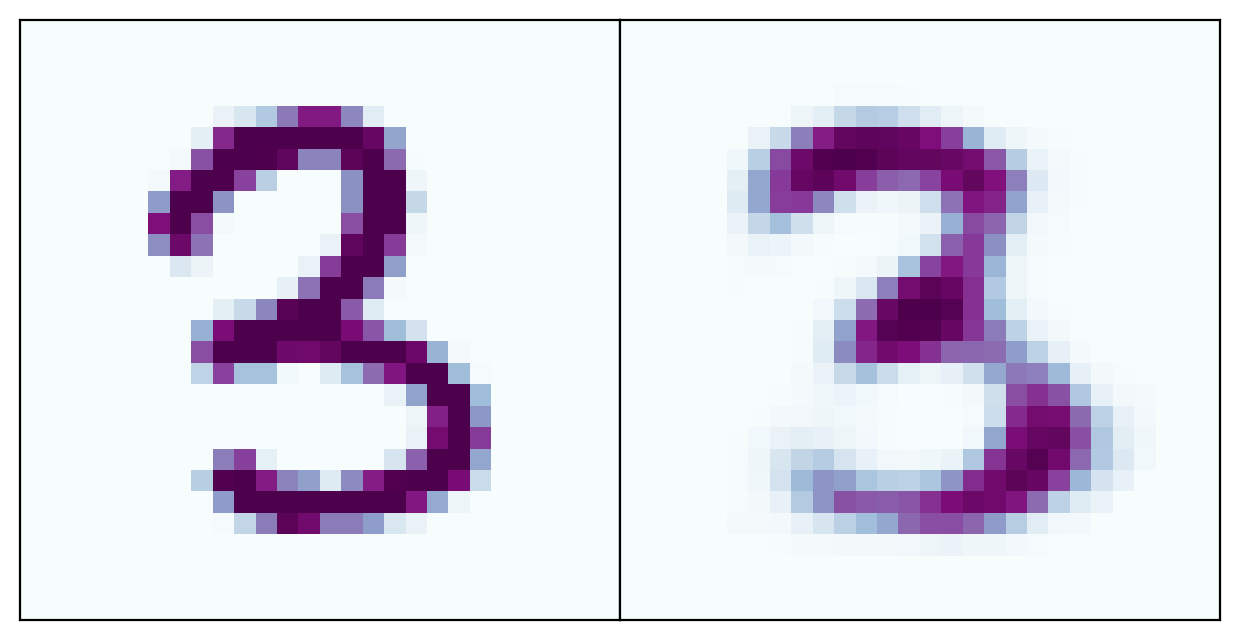

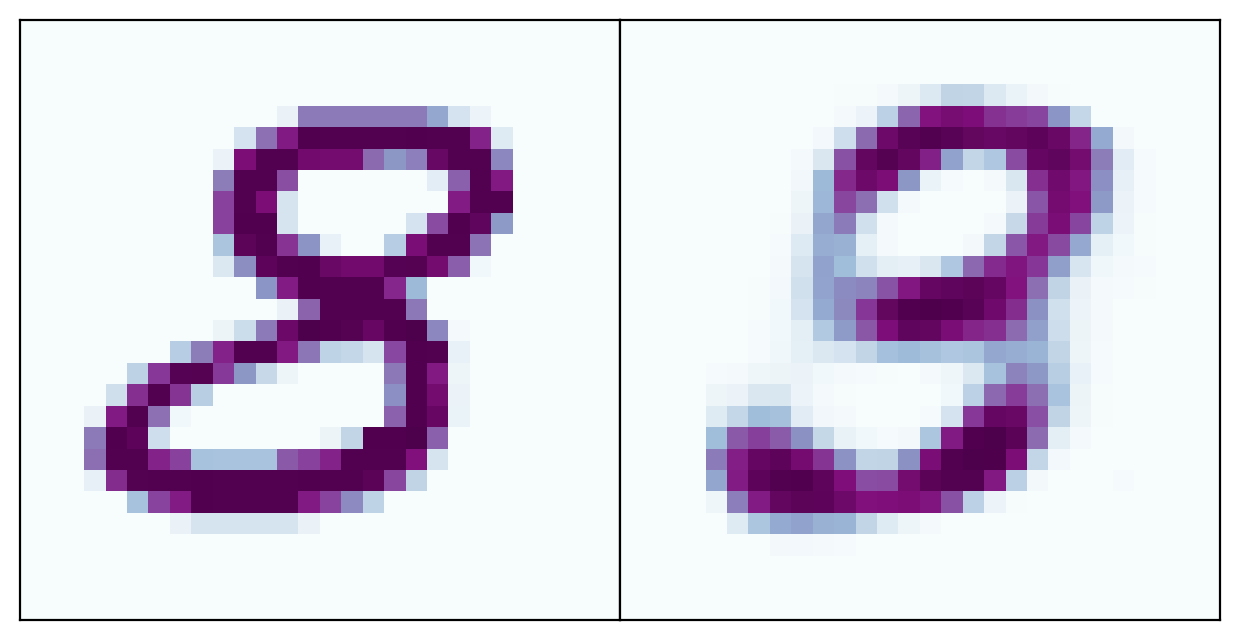

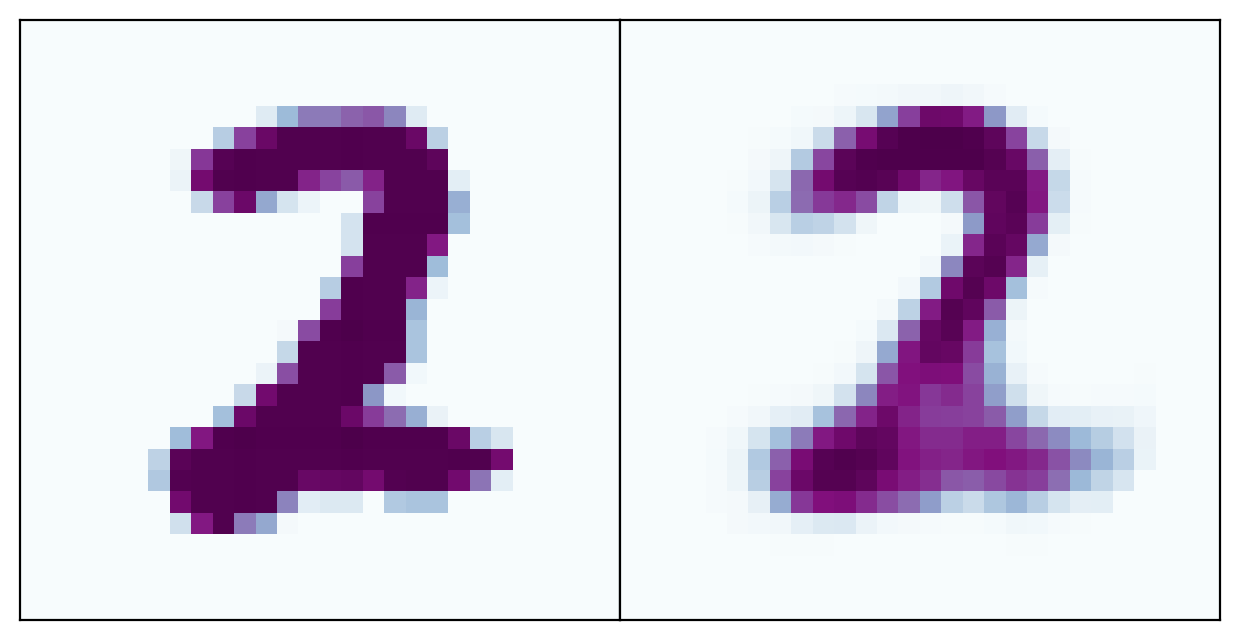

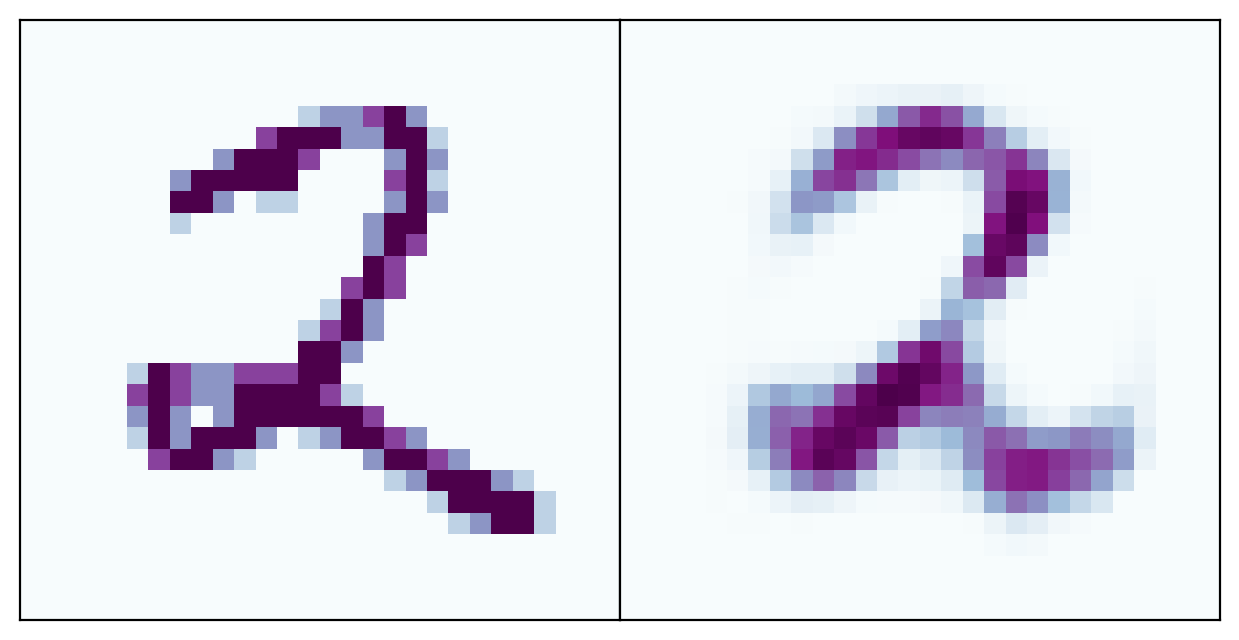

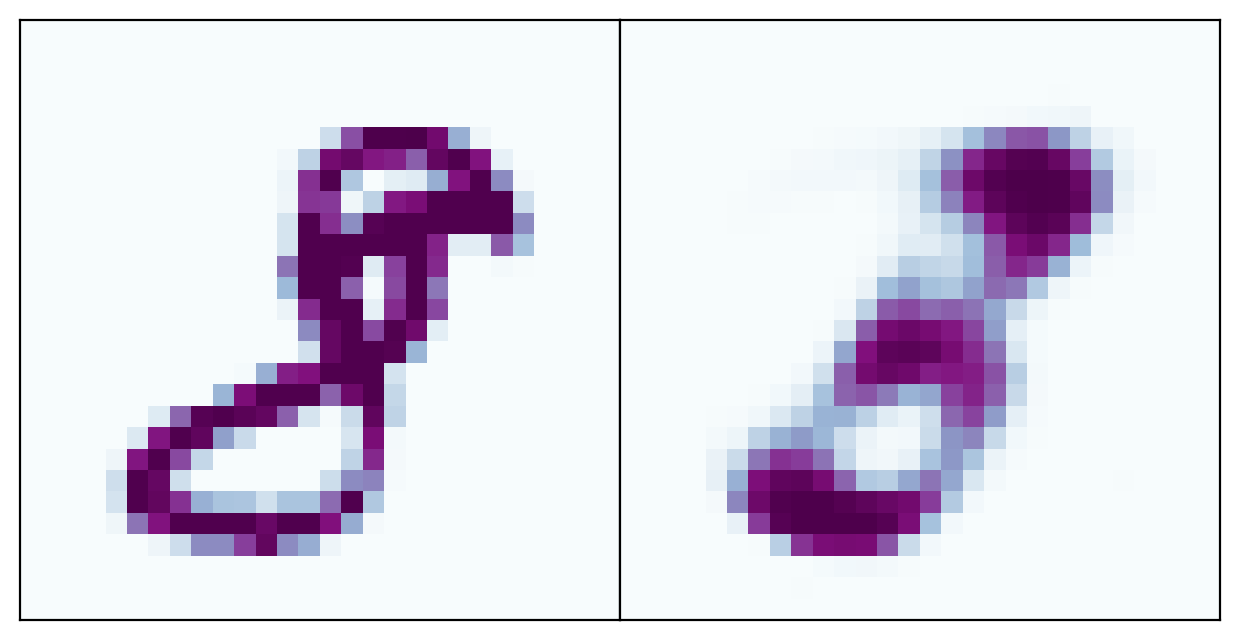

In [5]:
set_random_seed(seed=0)
imgs = [dataset[r] for r in random.sample(range(30_000), 5)]

for img, label in imgs:
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(img.view(28,28), cmap='BuPu');

    img_hat = autoencoder(img.view(1,1,784).to(device))
    ax2.imshow(img_hat.view(28,28).cpu().detach(), cmap='BuPu');
    ax2.set_xticks([])
    ax2.set_yticks([])

    plt.show()